In [ ]:
import kagglehub
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [ ]:
dataset_path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")
print("Dataset downloaded to:", dataset_path)
IMAGE_SIZE = (128, 128)
show_sample_image = None

Dataset downloaded to: /kaggle/input/lung-and-colon-cancer-histopathological-images


## Prepocessing



1.   Median
2.   Gaussian
3.   Resize
4.   Histogram Equalization



In [ ]:
def preprocess_image(img_path):
    global show_sample_image
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)

    if show_sample_image is None:
        show_sample_image = img.copy()  # Save original for visualization

    img = cv2.medianBlur(img, 3)
    img = cv2.GaussianBlur(img, (5, 5), 0)

    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YCrCb2BGR)

    return img

## Feature Extraction



1.   mean texture

2.   Standar Deviation texture
3.   Hu Moments


4.   flatten



In [ ]:
def extract_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    texture = cv2.createCLAHE().apply(gray)
    texture_mean = np.mean(texture)
    texture_std = np.std(texture)
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments).flatten()
    return [texture_mean, texture_std] + list(hu_moments)

## Load Data

In [ ]:
X, y = [], []
for organ_folder in ["colon_image_sets", "lung_image_sets"]:
    organ_path = os.path.join(dataset_path, "lung_colon_image_set", organ_folder)
    if not os.path.isdir(organ_path):
        continue

    # Loop ke folder kelas: colon_aca, colon_n, lung_aca, dll
    for class_folder in os.listdir(organ_path):
        class_path = os.path.join(organ_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        for img_file in tqdm(os.listdir(class_path), desc=f"Processing {class_folder}"):
            try:
                if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                img_path = os.path.join(class_path, img_file)

                img = preprocess_image(img_path)
                features = extract_features(img)

                X.append(features)
                y.append(class_folder)
            except Exception as e:
                print(f"Skipping {img_file}: {e}")


Processing lung_n: 100%|██████████| 5000/5000 [01:02<00:00, 80.48it/s]


In [ ]:
X = np.array(X)
le = LabelEncoder()
y = le.fit_transform(y)
class_names = le.classes_

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train Model

In [ ]:
!nvidia-smi

Sat May 10 05:41:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(solver='saga', max_iter=1000)
}

In [ ]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[name] = {
        "model": model,
        "y_pred": y_pred,
        "metrics": {
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1
        }
    }

## Visualisasi

In [ ]:
def show_preprocessing_result():
    # Ambil satu contoh gambar dari dataset
    sample_img_path = None
    for organ_folder in ["colon_image_sets", "lung_image_sets"]:
        organ_path = os.path.join(dataset_path, "lung_colon_image_set", organ_folder)
        if not os.path.isdir(organ_path):
            continue

        for class_folder in os.listdir(organ_path):
            class_path = os.path.join(organ_path, class_folder)
            if not os.path.isdir(class_path):
                continue

            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    sample_img_path = os.path.join(class_path, img_file)
                    break
            if sample_img_path:
                break
        if sample_img_path:
            break

    if sample_img_path is None:
        print("No sample image found.")
        return

    processed = preprocess_image(sample_img_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cv2.cvtColor(show_sample_image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[1].imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    ax[1].set_title("After Preprocessing")
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()


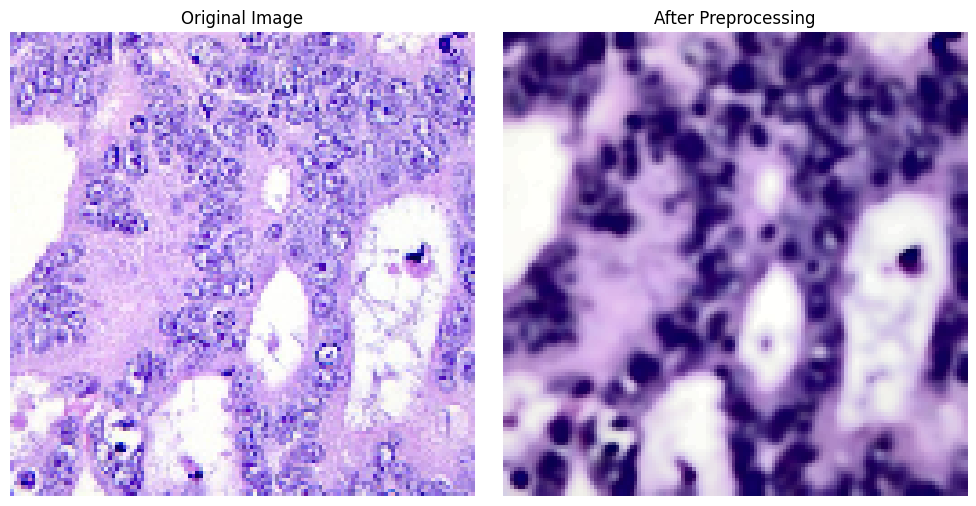

In [ ]:
show_preprocessing_result()

In [ ]:
def show_feature_vector():
    plt.figure(figsize=(10, 4))
    plt.plot(X[0], marker='o')
    plt.title("Contoh Vektor Fitur (1 gambar)")
    plt.xlabel("Index Fitur")
    plt.ylabel("Nilai")
    plt.grid(True)
    plt.show()

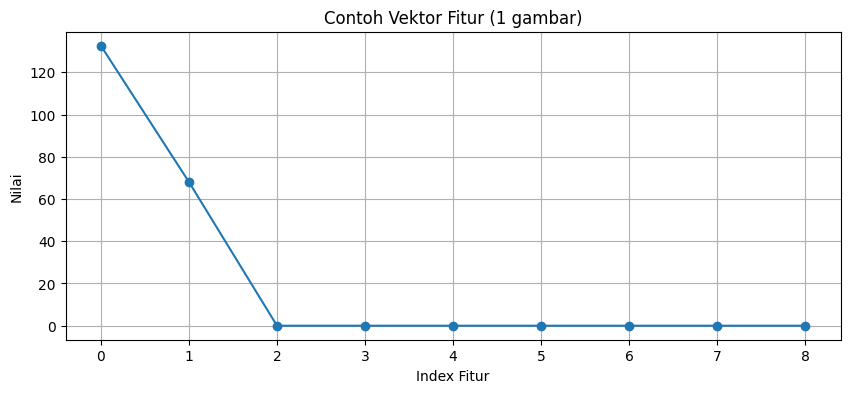

In [ ]:
show_feature_vector()

In [ ]:
def show_confusion_heatmap(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
def show_classification_examples(model, model_name):
    X_sample = X_test
    y_true = y_test
    y_pred = model.predict(X_sample)

    correct_idx = np.where(y_true == y_pred)[0][:3]
    wrong_idx = np.where(y_true != y_pred)[0][:3]

    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    fig.suptitle(f"{model_name} - Contoh Prediksi", fontsize=16)

    for i, idx in enumerate(correct_idx):
        img_path = None
        for organ_folder in ["colon_image_sets", "lung_image_sets"]:
            organ_path = os.path.join(dataset_path, "lung_colon_image_set", organ_folder)
            class_path = os.path.join(organ_path, class_names[y_true[idx]])
            if os.path.isdir(class_path):
                img_file = os.listdir(class_path)[idx % len(os.listdir(class_path))]
                img_path = os.path.join(class_path, img_file)
                break

        if img_path is None:
            continue

        img = cv2.imread(img_path)
        img = cv2.resize(img, IMAGE_SIZE)
        axes[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0, i].set_title(f"Benar: {class_names[y_true[idx]]}")
        axes[0, i].axis('off')

        # Tambahkan prediksi model di bawahnya (misalnya sebagai teks atau bar chart)
        probs = model.predict_proba(X_sample[idx].reshape(1, -1))[0]
        axes[1, i].bar(class_names, probs)
        axes[1, i].set_ylim([0, 1])
        axes[1, i].set_title(f"Pred: {class_names[np.argmax(probs)]}")


    plt.tight_layout()
    plt.show()



📊 Random Forest Metrics:
Accuracy: 0.7682
Precision: 0.7678
Recall: 0.7682
F1-Score: 0.7668


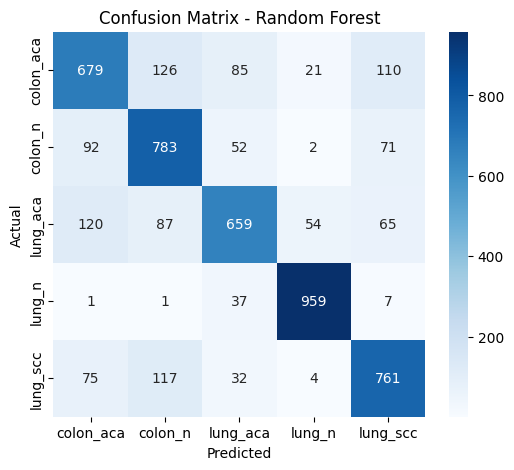

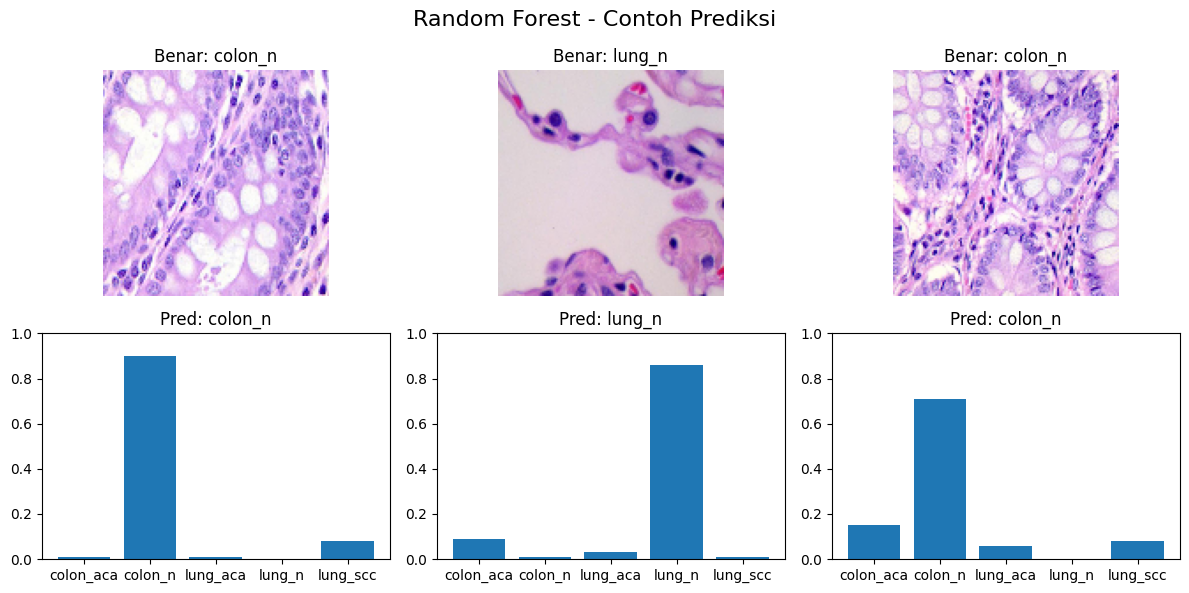


📊 SVM Metrics:
Accuracy: 0.4706
Precision: 0.4460
Recall: 0.4706
F1-Score: 0.4209


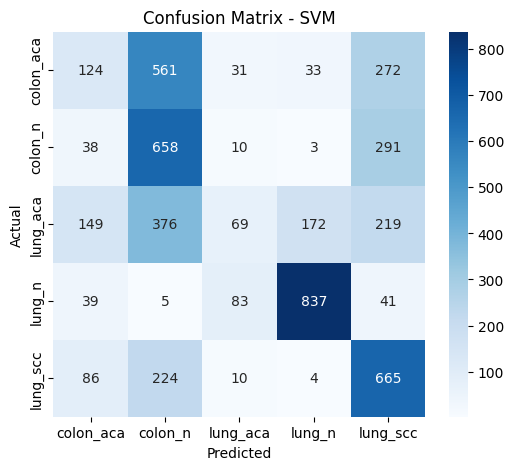

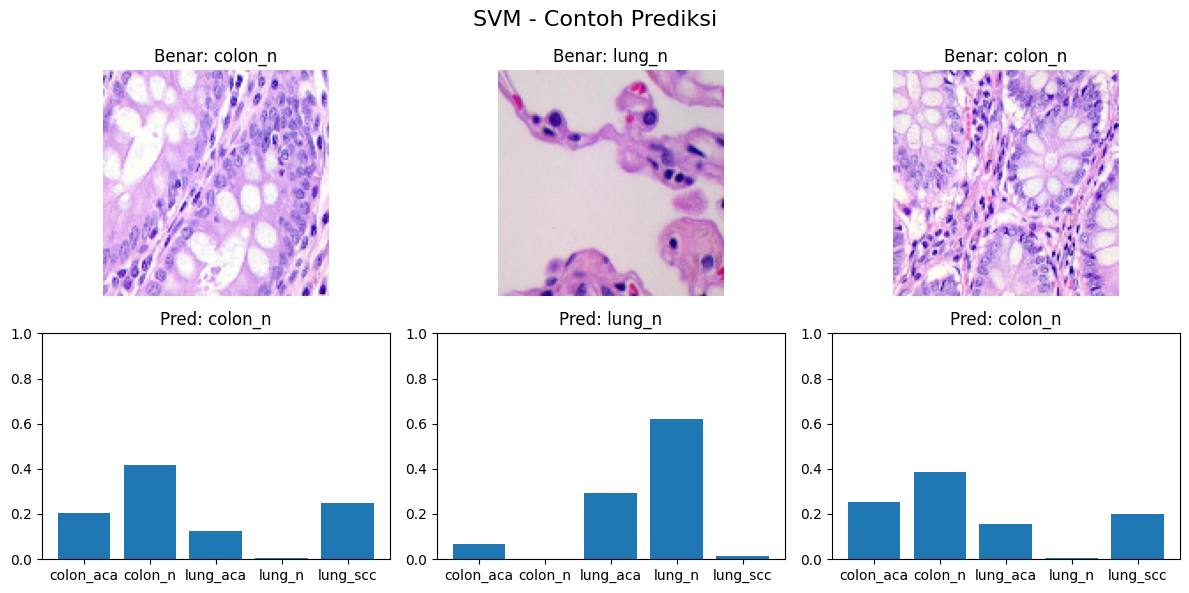


📊 Logistic Regression Metrics:
Accuracy: 0.4190
Precision: 0.4156
Recall: 0.4190
F1-Score: 0.4105


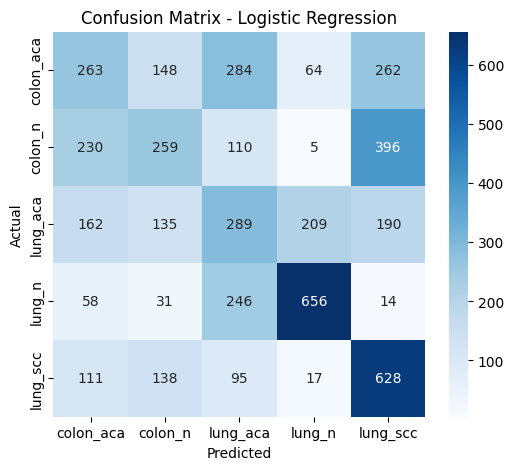

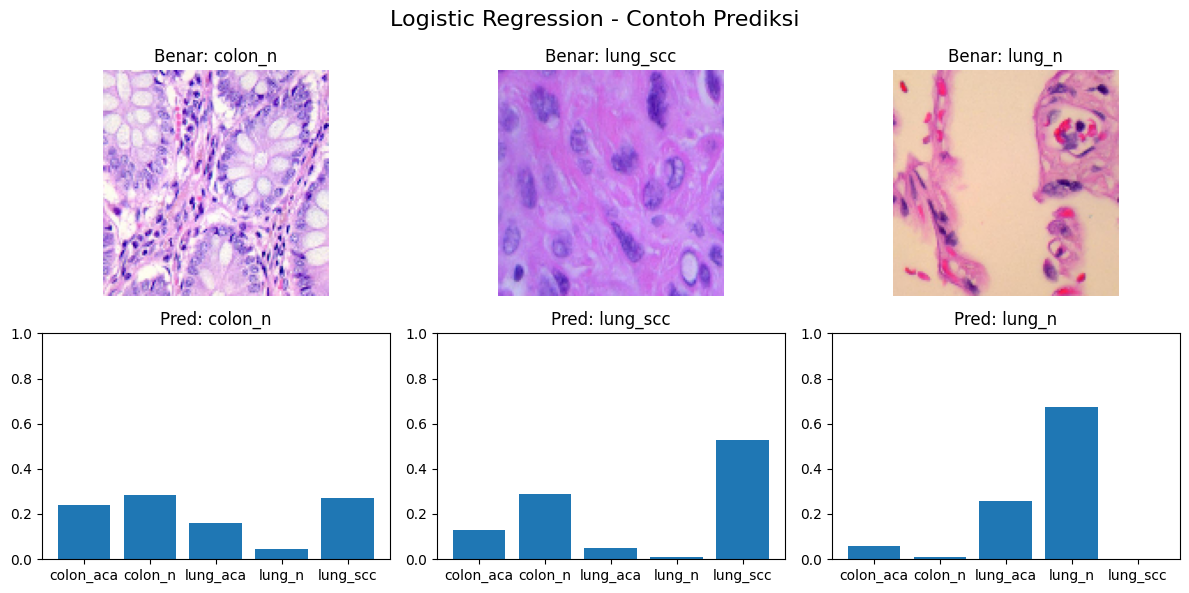

In [ ]:
for name, result in results.items():
    print(f"\n📊 {name} Metrics:")
    for k, v in result['metrics'].items():
        print(f"{k}: {v:.4f}")
    show_confusion_heatmap(name, y_test, result['y_pred'])
    show_classification_examples(result['model'], name)